<a href="https://colab.research.google.com/github/jchen42703/MathResearchQHSS/blob/master/KMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a simple neural network for KMNIST written in PyTorch. 

In [0]:
device = 'cuda' #Enables GPU use
!pip3 install torch torchvision


#Dependencies 
import numpy as np
import torch 
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import KMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [0]:
#Set seeds for reproducibility 
torch.manual_seed(42042069)
np.random.seed(42042069)

In [0]:
#Define transformations; Convert data to tensors and normalize 
train_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.1307], [0.3081])])
valid_transform = train_transform

In [0]:
#Download KMNIST data
train_set = KMNIST('./data/kmnist', train=True, download=True, transform=train_transform)
valid_set = KMNIST('./data/kmnist', train=False, download=True, transform=valid_transform)

In [0]:
#Print shapes of the dataset
print(train_set.train_data.shape)
print(valid_set.test_data.shape)


torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor(7)


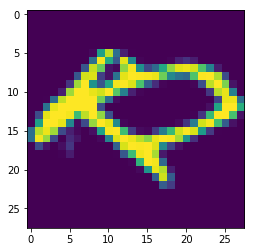

In [0]:
#Display a single digit
plt.figure()
plt.imshow(train_set.train_data[20])
print(train_set.train_labels[20])

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


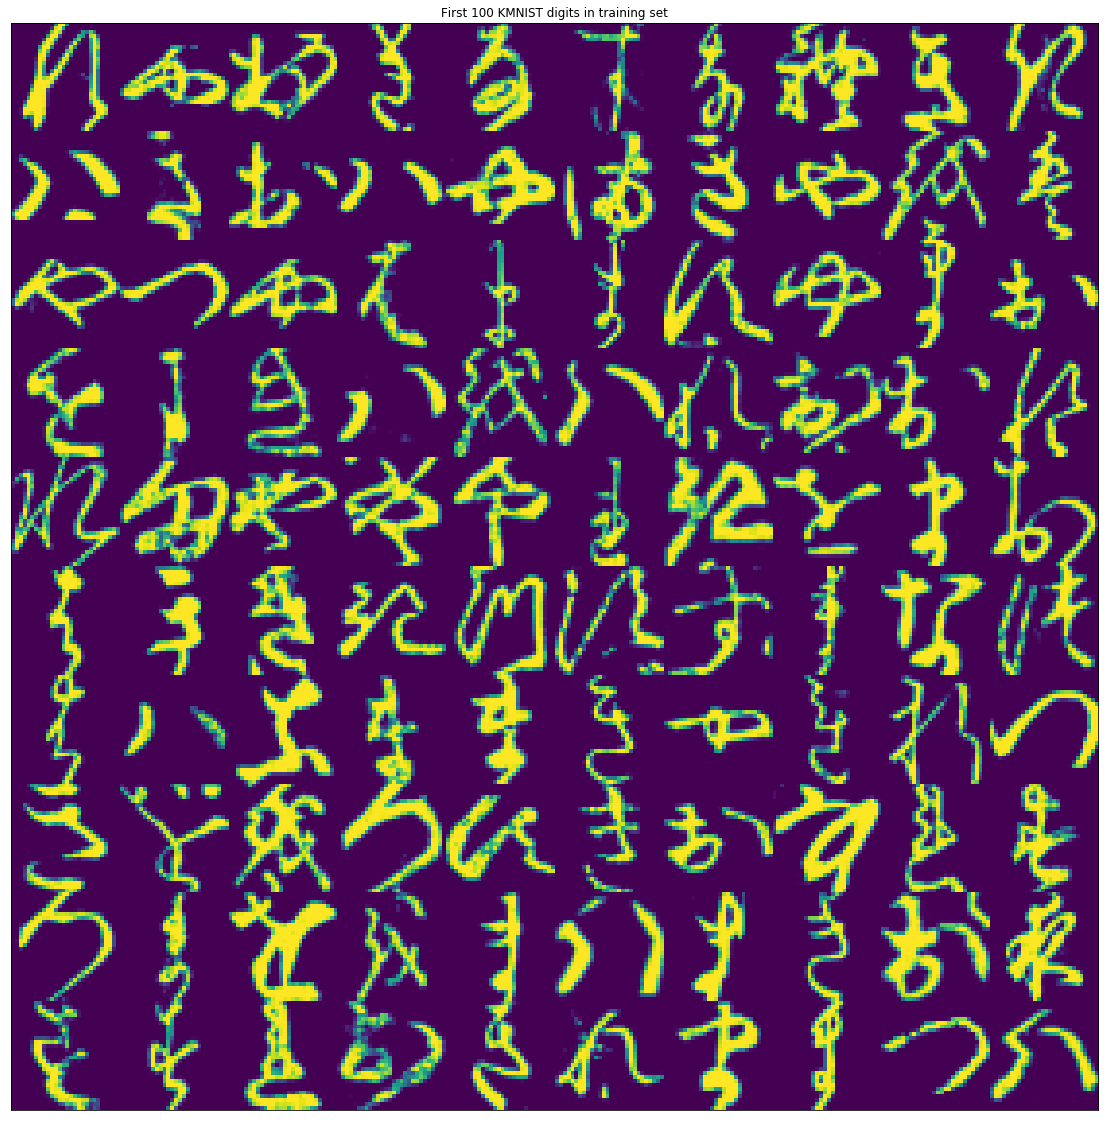

Labels: [8 7 0 1 4 2 4 8 1 1 5 1 0 5 7 6 1 7 9 5 7 3 7 5 6 6 2 7 6 0 9 6 1 5 9 5 8
 0 0 8 8 6 7 7 7 8 1 9 6 0 5 1 1 1 3 2 2 6 4 3 5 5 4 6 6 1 7 8 8 3 1 9 9 3
 2 1 0 4 8 2 3 6 9 9 6 5 6 1 0 7 2 2 8 0 1 8 6 6 3 5]


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [0]:
plt.figure(figsize=(20,20))

sample = train_set.train_data[:100]
# shape (64, 28, 28)
sample = sample.reshape(10,10,28,28)
# shape (8, 8, 28, 28)
sample = sample.permute(0,2,1,3)
# shape (8, 28, 8, 28)
sample = sample.reshape(10*28,10*28)
# shape (8*28, 8*28)
plt.imshow(sample)
plt.xticks([])
plt.yticks([])
plt.grid(True)
plt.title('First 100 KMNIST digits in training set')
plt.show()

print('Labels:', train_set.train_labels[:100].numpy())

In [0]:
#Initialize data loaders
train_loader = DataLoader(train_set, batch_size=269, num_workers=0, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=690, num_workers=0, shuffle=False)


In [0]:
#Create neural network
class Mendes_NN(nn.Module):
  
  def __init__(self, num_channels=1, num_classes=10):
    super(Mendes_NN, self).__init__()
    hidden_1 = 420 
    hidden_2 = 420
    hidden_3 = 420
    self.fc1 = nn.Linear(28 * 28, hidden_1)
    self.fc2 = nn.Linear(hidden_1, hidden_2)
    self.fc3 = nn.Linear(hidden_2, hidden_3)
    self.fc4 = nn.Linear(hidden_3, 10)
    self.dropout = nn.Dropout(0.4)
    
  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.dropout(x)
    x = self.fc4(x)
    return x #logits
    

In [0]:
#Elucidates progress
class AverageBase(object):
    
    def __init__(self, value=0):
        self.value = float(value) if value is not None else None
       
    def __str__(self):
        return str(round(self.value, 4))
    
    def __repr__(self):
        return self.value
    
    def __format__(self, fmt):
        return self.value.__format__(fmt)
    
    def __float__(self):
        return self.value
    

class RunningAverage(AverageBase):
    """
    Keeps track of a cumulative moving average (CMA).
    """
    
    def __init__(self, value=0, count=0):
        super(RunningAverage, self).__init__(value)
        self.count = count
        
    def update(self, value):
        self.value = (self.value * self.count + float(value))
        self.count += 1
        self.value /= self.count
        return self.value


class MovingAverage(AverageBase):
    """
    An exponentially decaying moving average (EMA).
    """
    
    def __init__(self, alpha=0.99):
        super(MovingAverage, self).__init__(None)
        self.alpha = alpha
        
    def update(self, value):
        if self.value is None:
            self.value = float(value)
        else:
            self.value = self.alpha * self.value + (1 - self.alpha) * float(value)
        return self.value


from IPython.display import HTML, display

#Creates a progress bar 
class ProgressMonitor(object):
    """
    Custom IPython progress bar for training
    """
    
    tmpl = """
        <p>Loss: {loss:0.4f}   {value} / {length}</p>
        <progress value='{value}' max='{length}', style='width: 100%'>{value}</progress>
    """

    def __init__(self, length):
        self.length = length
        self.count = 0
        self.display = display(self.html(0, 0), display_id=True)
        
    def html(self, count, loss):
        return HTML(self.tmpl.format(length=self.length, value=count, loss=loss))
        
    def update(self, count, loss):
        self.count += count
        self.display.update(self.html(self.count, loss))
        

#Creates checkpoints for the model 
def save_checkpoint(optimizer, model, epoch, filename):
    checkpoint_dict = {
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
        'epoch': epoch
    }
    torch.save(checkpoint_dict, filename)


def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

In [0]:
#Initialize neural network
model = Mendes_NN()
model.to(device)

Mendes_NN(
  (fc1): Linear(in_features=784, out_features=420, bias=True)
  (fc2): Linear(in_features=420, out_features=420, bias=True)
  (fc3): Linear(in_features=420, out_features=420, bias=True)
  (fc4): Linear(in_features=420, out_features=10, bias=True)
  (dropout): Dropout(p=0.4)
)

In [0]:
#Utilizes the Adadelta algorithm for optimization
optimizer = optim.Adadelta(model.parameters(), lr=0.01)

In [0]:
!mkdir -p checkpoints

In [0]:
#Creates a function for training the model 
def train(optimizer, model, num_epochs=9, first_epoch=1 ):
  
  criterion = nn.CrossEntropyLoss()
  
  train_losses = []
  valid_losses = []
  
  for epoch in range(first_epoch, first_epoch + num_epochs):
    print("Epoch", epoch)
    
    #training phase
    
    model.train()
    
    #create a progress bar
    progress = ProgressMonitor(length=len(train_set))
    
    train_loss = MovingAverage()
    
    for batch, targets in train_loader:
      
      #Move to GPU 
      batch = batch.to(device)
      targets = targets.to(device)
      
      #clear out 
      optimizer.zero_grad()
      
      #run forward prop
      predictions = model(batch)
      
      #calculate loss 
      loss = criterion(predictions, targets)
      
      #backprop
      loss.backward()
      
      #update parameters
      optimizer.step()
      
      #update average loss
      train_loss.update(loss)
      
      #update progress bar
      progress.update(batch.shape[0], train_loss)
      
    print('Training loss:', train_loss)
    train_losses.append(train_loss.value)
    
    
    #validation phase
    model.eval()
    
    valid_loss = RunningAverage()
    
    #keep track of predictions'
    y_pred = []
    
    
    with torch.no_grad():
      
      for batch, targets in valid_loader:
        
        #Move to GPU 
        batch = batch.to(device)
        targets = targets.to(device)

        #clear out 
        optimizer.zero_grad()

        #running forward prop
        predictions = model(batch)

        #calculate loss 
        loss = criterion(predictions, targets)

        #update average loss
        valid_loss.update(loss)
        
        y_pred.extend(predictions.argmax(dim=1).cpu().numpy())
        
    print('validation loss', valid_loss)
    valid_losses.append(valid_loss.value)
    
    #Calculate validation accuracy 
    y_pred = torch.tensor(y_pred, dtype=torch.int64)
    accuracy = torch.mean((y_pred == valid_set.test_labels).float())
    print('Validation accuracy: {:.4f}%'.format(float(accuracy) * 100))
    
    # Save a checkpoint
    checkpoint_filename = 'checkpoints/kmnist-{:03d}.pkl'.format(epoch)
    save_checkpoint(optimizer, model, epoch, checkpoint_filename)
    
  return train_losses, valid_losses, y_pred


        
        

In [0]:
train_losses, valid_losses, y_pred = train(optimizer, model, num_epochs=10) #Train

Epoch 1


Training loss: 2.2468
validation loss 2.2137
Validation accuracy: 32.4700%
Epoch 2


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Training loss: 1.9499
validation loss 1.8951
Validation accuracy: 44.2100%
Epoch 3


Training loss: 1.4226
validation loss 1.5445
Validation accuracy: 52.7200%
Epoch 4


Training loss: 1.0816
validation loss 1.3317
Validation accuracy: 58.5200%
Epoch 5


Training loss: 0.8994
validation loss 1.1862
Validation accuracy: 63.2100%
Epoch 6


Training loss: 0.7855
validation loss 1.0983
Validation accuracy: 65.0700%
Epoch 7


Training loss: 0.7255
validation loss 1.0373
Validation accuracy: 66.8500%
Epoch 8


Training loss: 0.6628
validation loss 0.977
Validation accuracy: 68.6800%
Epoch 9


Training loss: 0.6364
validation loss 0.9383
Validation accuracy: 69.6600%
Epoch 10


Training loss: 0.5846
validation loss 0.897
Validation accuracy: 70.7600%


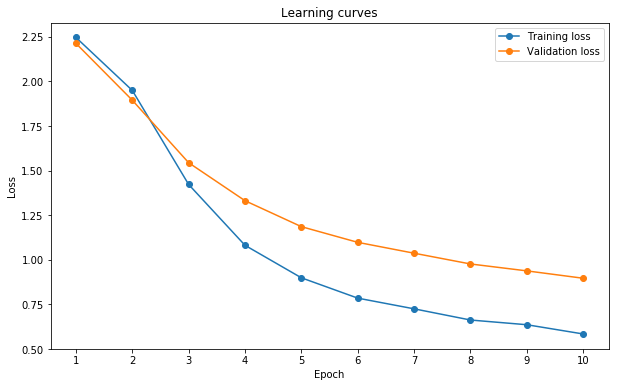

In [0]:
#Graph training and validation loss
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, train_losses, '-o', label='Training loss')
plt.plot(epochs, valid_losses, '-o', label='Validation loss')
plt.legend()
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.show()